In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt, log10

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = False  # plot every steps

In [2]:
from floorplan_analysis import read_bgr_from_image_unicode, get_unit_mask
from floorplan_analysis import align_fp, rescale_fp

In [3]:
cv2.__version__

'4.2.0'

In [4]:
bgr = read_bgr_from_image_unicode("/fp_img/10001_57B.jpg")
# 9765_107A 누워있는
# 1776_105 코어
# 102487_266B 비사각

# 199_86
# 6_87
# 2_63
# 8_99

# 107323_110B 흰 영역 날아감

# 10001_57B 발코니 없음

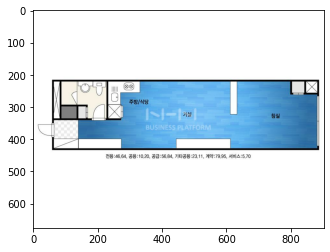

In [5]:
plt.imshow(bgr)

In [6]:
unit_comb_orig = get_unit_mask(bgr)

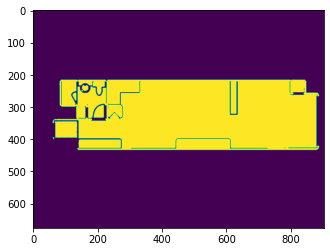

In [7]:
plt.imshow(np.bitwise_or.reduce(unit_comb_orig, 2))

In [8]:
cv2.countNonZero(unit_comb_orig[:, :, 4])

0

right


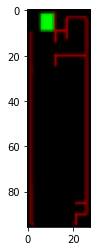

In [9]:
unit_comb = rescale_fp(unit_comb_orig.copy(), 85)
unit_comb = align_fp(unit_comb)

plt.imshow(unit_comb[:, :, [0, 1, 4]])

In [10]:
# AREA_WALL = 64
# AREA_ENTRANCE = 32
# AREA_LDK = 16
# AREA_BEDROOM = 8
# AREA_BALCONY = 4
# AREA_BATHROOM = 2

mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)

In [11]:
# binary cut value
cut = 0.01 * np.ones(6)
for i in range(6):
    if cv2.countNonZero(unit_comb[:, :, i]):
        cut[i] = (
            np.average(unit_comb[:, :, i][np.nonzero(unit_comb[:, :, i] > 0)]) - 0.01
        )

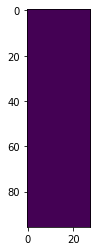

In [12]:
plt.imshow((unit_comb > cut)[:, :, 4])

In [13]:
mono = ((unit_comb > cut) * 255) & mask_bits

In [14]:
mono.shape, mono.dtype

((96, 28, 6), dtype('int64'))

In [15]:
np.amax(mono[:, :, 2])

16

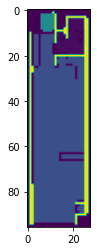

In [16]:
mono = np.bitwise_or.reduce(mono, 2)
plt.imshow(mono)

In [17]:
def mono_fp(unit_comb):
    """create bit mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""

    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)

    # binary cut value
    cut = 0.01 * np.ones(6)
    for i in range(6):
        if cv2.countNonZero(unit_comb[:, :, i]):
            cut[i] = (
                np.average(unit_comb[:, :, i][np.nonzero(unit_comb[:, :, i] > 0)])
                - 0.01
            )

    mono = ((unit_comb > cut) * 255).astype(np.uint8) & mask_bits
    mono = np.bitwise_or.reduce(mono, 2)
    return mono